<a href="https://www.kaggle.com/code/stephenparvin/store-sales-time-series-forecasting?scriptVersionId=92450865" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
df_holiday_events = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv')
df_oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv')
df_sample = pd.read_csv('../input/store-sales-time-series-forecasting/sample_submission.csv')
df_stores = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv')
df_train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv')
df_transactions = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv')

<AxesSubplot:xlabel='date'>

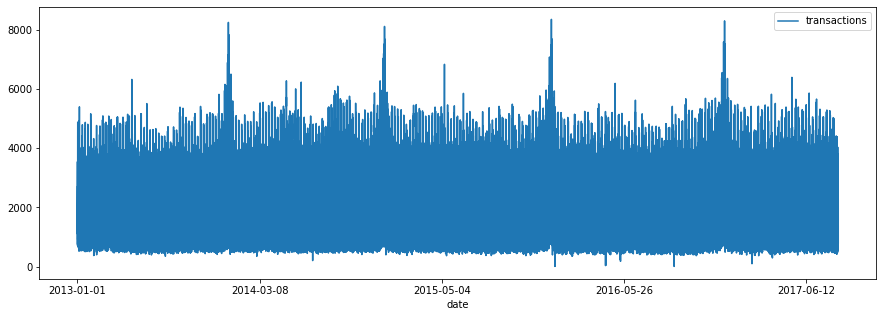

In [3]:
df_transactions.plot(x='date', y='transactions',figsize=(15,5))

In [4]:
df_trans_high_sales = df_transactions.query('transactions > 8000')

In [5]:
# highest volume of sales appears to be around Christmas (Navidad)
df_trans_high_sales

,date,store_nbr,transactions
16570,2013-12-23,44,8256
16572,2013-12-23,46,8001
33700,2014-12-23,44,8120
52011,2015-12-23,44,8359
71010,2016-12-23,44,8307


In [6]:
df_trans_high_sales.max()

date            2016-12-23
store_nbr               46
transactions          8359
dtype: object

In [7]:
# total sales for each store
df_store_totals = df_transactions.groupby(by="store_nbr").sum()
df_store_totals.info

<bound method DataFrame.info of            transactions
store_nbr              
1               2553963
2               3219901
3               5366350
4               2519007
5               2347877
6               3065896
7               2995993
8               4637971
9               3516162
10              1652493
11              3972488
12              1958852
13              1572504
14              2287850
15              2209898
16              1464498
17              2295485
18              2071278
19              2107489
20              1422539
21               842891
22               504156
23              1788171
24              3568206
25              1520362
26              1065059
27              2485687
28              1957594
29               981448
30              1171130
31              2306044
32              1065226
33              1743003
34              3864018
35              1123889
36              1738129
37              2481719
38              2867052
39      

In [8]:
# get the total transactions of a specific store
# both return Store # 25
print(df_store_totals.iat[24,0]) # using the index of the row (starts with 0)
print(df_store_totals.at[25, 'transactions']) # using the store number value

1520362
1520362


In [9]:
# get the store by the index name
df_store_totals.loc[25]

transactions    1520362
Name: 25, dtype: int64

In [10]:
# return a dataframe of specific rows
df_store_totals.loc[[1,2,3,25]]

,transactions
store_nbr,
1,2553963
2,3219901
3,5366350
25,1520362


In [11]:
# get stores based on performance level
df_store_totals.loc[df_store_totals['transactions']<1000000]

,transactions
store_nbr,
21,842891
22,504156
29,981448
42,802646
52,275393


In [12]:
df_store_totals.sum()

transactions    141478945
dtype: int64

In [13]:
# get each transaction of a certain store
df_store1 = df_transactions.query('store_nbr == 1')
#df_store1.groupby(level=0)
df_store1

,date,store_nbr,transactions
1,2013-01-02,1,2111
47,2013-01-03,1,1833
93,2013-01-04,1,1863
139,2013-01-05,1,1509
185,2013-01-06,1,520
...,...,...,...
83218,2017-08-11,1,570
83272,2017-08-12,1,1004
83326,2017-08-13,1,416
83380,2017-08-14,1,1733


In [14]:
df_transactions['store_nbr'].max()

54

# Notes on concatenation
To place dataframes "side by side":
* pd.concat([df1, df2], axis=1)

To place dataframes "one underneath the other":
* pd.concat([df1, df2], axis=0)

In [15]:
df_train.loc[df_train['sales'] > 0]

,id,date,store_nbr,family,sales,onpromotion
563,563,2013-01-01,25,BEAUTY,2.000,0
564,564,2013-01-01,25,BEVERAGES,810.000,0
566,566,2013-01-01,25,BREAD/BAKERY,180.589,0
568,568,2013-01-01,25,CLEANING,186.000,0
569,569,2013-01-01,25,DAIRY,143.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [16]:
df_stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [17]:
df_store_totals.reset_index()

,store_nbr,transactions
0,1,2553963
1,2,3219901
2,3,5366350
3,4,2519007
4,5,2347877
5,6,3065896
6,7,2995993
7,8,4637971
8,9,3516162
9,10,1652493


In [18]:
# here we can see that df_stores index is from 0 to 53,
# but df_store_totals index is 1 to 54
print(df_stores.info())
print(df_store_totals.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 1 to 54
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   transactions  54 non-null     int64
dtypes: int64(1)
memory usage: 2.9 KB
None


In [19]:
# in order to concat stores and transactions, we must reset
# the index so that the stores line up properly. otherwise
# the data will be off by one row
# run reset_index() on df_store_totals to make the data line up properly
df_store_totals = df_store_totals.reset_index()

In [20]:
# both of these df's have the same column 'store_nbr'. We only want one of 
# those columns, so concat only 'transactions' from df_store_totals to avoid
# duplicate columns
df_stores_and_trans = pd.concat([df_stores, df_store_totals['transactions']], axis=1)

In [21]:
# now we can see that Store 1 correctly has 2553963 transactions,
# and only one column for store_nbr
df_stores_and_trans.head()

,store_nbr,city,state,type,cluster,transactions
0,1,Quito,Pichincha,D,13,2553963
1,2,Quito,Pichincha,D,13,3219901
2,3,Quito,Pichincha,D,8,5366350
3,4,Quito,Pichincha,D,9,2519007
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,2347877


In [22]:
# what can we learn from the 'cluster'?
df_stores_and_trans['cluster'].value_counts()

3     7
6     6
10    6
15    5
13    4
14    4
11    3
4     3
8     3
1     3
9     2
7     2
2     2
12    1
5     1
16    1
17    1
Name: cluster, dtype: int64

In [23]:
# which clusters performed the best?
df_stores_and_trans.groupby(['cluster']).sum()

,store_nbr,transactions
cluster,,
1,76,7574255
2,79,3284365
3,240,10200231
4,84,6979075
5,44,7273093
6,134,16007580
7,36,2792006
8,18,13000314
9,27,4307178


In [24]:
# set the index to 'store_nbr' so that index[x] will
# refer to store_nbr[x]
df_stores_and_trans.set_index('store_nbr')

,city,state,type,cluster,transactions
store_nbr,,,,,
1,Quito,Pichincha,D,13,2553963
2,Quito,Pichincha,D,13,3219901
3,Quito,Pichincha,D,8,5366350
4,Quito,Pichincha,D,9,2519007
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,2347877
6,Quito,Pichincha,D,13,3065896
7,Quito,Pichincha,D,8,2995993
8,Quito,Pichincha,D,8,4637971
9,Quito,Pichincha,B,6,3516162


In [25]:
# what do the different "types" look like?
df_stores_and_trans['type'].value_counts()

D    18
C    15
A     9
B     8
E     4
Name: type, dtype: int64

In [26]:
# the cluster with the highest transactions
# all type A
df_stores_and_trans.loc[df_stores_and_trans['cluster'] == 14]

,store_nbr,city,state,type,cluster,transactions
45,46,Quito,Pichincha,A,14,5990113
46,47,Quito,Pichincha,A,14,6535810
47,48,Quito,Pichincha,A,14,5107785
49,50,Ambato,Tungurahua,A,14,4384444


In [27]:
df_type_a = df_stores_and_trans.loc[df_stores_and_trans['type'] == 'A']
df_type_b = df_stores_and_trans.loc[df_stores_and_trans['type'] == 'B']
df_type_c = df_stores_and_trans.loc[df_stores_and_trans['type'] == 'C']
df_type_d = df_stores_and_trans.loc[df_stores_and_trans['type'] == 'D']
df_type_e = df_stores_and_trans.loc[df_stores_and_trans['type'] == 'E']

In [28]:
df_type_a_sum = df_type_a['transactions'].sum()
df_type_b_sum = df_type_b['transactions'].sum()
df_type_c_sum = df_type_c['transactions'].sum()
df_type_d_sum = df_type_d['transactions'].sum()
df_type_e_sum = df_type_e['transactions'].sum()

In [29]:
# Make a new DataFrame with the total transactions for each Store Type
df_type_data = [('A', df_type_a_sum),('B', df_type_b_sum),('C', df_type_c_sum),('D', df_type_d_sum),('E', df_type_e_sum),]
df_type_trans = pd.DataFrame(df_type_data, columns=['Store Type', 'Transactions'])

In [30]:
df_type_trans

,Store Type,Transactions
0,A,43215470
1,B,20384902
2,C,24788958
3,D,46230088
4,E,6859527


In [31]:
df_type_trans = df_type_trans.set_index('Store Type')

<AxesSubplot:xlabel='Store Type'>

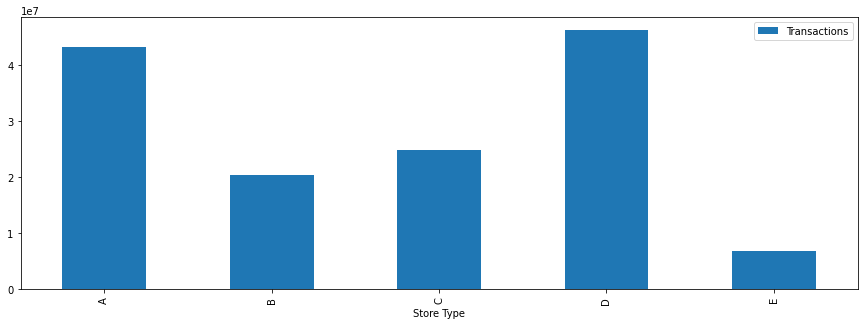

In [32]:
df_type_trans.plot(kind='bar', y='Transactions', figsize=(15,5))

In [33]:
df_type_a['transactions'].describe()

count    9.000000e+00
mean     4.801719e+06
std      2.150877e+06
min      2.753930e+05
25%      4.384444e+06
50%      5.107785e+06
75%      6.201115e+06
max      7.273093e+06
Name: transactions, dtype: float64

In [34]:
df_type_b['transactions'].describe()

count    8.000000e+00
mean     2.548113e+06
std      1.145388e+06
min      8.428910e+05
25%      1.909093e+06
50%      2.347763e+06
75%      3.603126e+06
max      3.972488e+06
Name: transactions, dtype: float64

In [35]:
df_type_c['transactions'].describe()

count    1.500000e+01
mean     1.652597e+06
std      5.327374e+05
min      5.041560e+05
25%      1.311210e+06
50%      1.652493e+06
75%      2.144342e+06
max      2.295485e+06
Name: transactions, dtype: float64

In [36]:
df_type_d['transactions'].describe()

count    1.800000e+01
mean     2.568338e+06
std      1.182723e+06
min      8.026460e+05
25%      1.770152e+06
50%      2.502347e+06
75%      3.048420e+06
max      5.366350e+06
Name: transactions, dtype: float64

In [37]:
df_type_e['transactions'].describe()

count    4.000000e+00
mean     1.714882e+06
std      5.215064e+05
min      9.814480e+05
25%      1.548959e+06
50%      1.847862e+06
75%      2.013784e+06
max      2.182356e+06
Name: transactions, dtype: float64

# Some Insights

By analyzing the store type we see that although Type D appears to be most successful in terms of having the most total transactions, the reason for that is that there are more stores of Type D than any other type.  Type A has half as many stores as Type D, but almost as many total transactions.  On closer inspection, Type A stores have a mean of 4.801719e+06 transactions, which is much higher than Type D at a mean of 2.568338e+06 transactions.

# To Do:
* Figure out how to work with the Dates of the Transactions
* Explore the relationships between Transactions, Store Types and Store Clusters
* Discover which Holidays and Events drive more Transactions
* Integrate the Oil data
* Build a ML model to predict transactions in the future